# 1.项目简介：
## 1.1 此项目为AI创造营第二期作业项目，fork[【AI创造营】使用 PaddleHub 结合 PaddleOCR 实现车牌识别](https://aistudio.baidu.com/aistudio/projectdetail/1603924)项目实现。
## 1.2 ccpd车牌检测数据集加载[CCPD PDRC 中科大-车牌数据集](https://aistudio.baidu.com/aistudio/datasetdetail/17968)，更详细信息可看数据集给出的，源数据集地址[https://github.com/detectRecog/CCPD](https://github.com/detectRecog/CCPD)
## 1.3 第二个用到的数据集是车牌识别数据集[characterDatahttps](https://aistudio.baidu.com/aistudio/datasetdetail/47799)。参考[深度学习7日入门-CV疫情特辑](https://aistudio.baidu.com/aistudio/education/group/info/1149)课程车牌识别项目，实现cnn识别车牌信息。此部分暂未实现。

In [ ]:
!python -m pip install --upgrade pip

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/6a/df/a6ef77a6574781a668791419ffe366c8acd1c3cf4709d210cb53cd5ce1c2/pip-22.0.3-py3-none-any.whl (2.1 MB)
  Attempting uninstall: pip
    Found existing installation: pip 21.3.1
    Uninstalling pip-21.3.1:
ERROR: Could not install packages due to an OSError: [Errno 13] Permission denied: 'WHEEL'
Consider using the `--user` option or check the permissions.

You should consider upgrading via the '/opt/conda/envs/python35-paddle120-env/bin/python -m pip install --upgrade pip' command.


# 2. 车牌检测数据集准备

## 2.1  数据集的准备与介绍

In [ ]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. 
# This directory will be recovered automatically after resetting environment. 
!cd /home/aistudio/
!ls /home/aistudio/data

data17968


## 2.2 解压数据集

In [ ]:
#解压数据集到项目主页
!unzip -q data/data17968/CCPD2019.zip -d ./CCPD2019

In [ ]:
#解压数据集到项目主页
!unzip -q data/data47799/characterData.zip -d ./characterData

In [ ]:
# 查看数据集的目录结构
# !tree data/xxx/xxx -d
! tree CCPD2019 -d

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


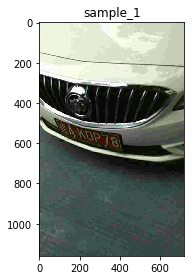

In [ ]:
# CCPD数据集抽样可视化
import cv2
#from IPython.display import Image
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

image_path_list = ['/home/aistudio/CCPD2019/ccpd_base/0752-14_32-72&473_423&652-423&652_102&567_72&473_393&558-0_0_9_24_13_31_32-40-161.jpg']
if not os.path.exists(image_path_list):
    image_path_list = ['/home/aistudio/CCPD2019/ccpd_base/ccpd_base0.jpg']
plt.figure()
plt.plot()
plt.title('sample_1')
plt.imshow(cv2.imread(image_path_list[0]))
plt.tight_layout()
plt.show()

## 2.3 图像数据的统计分析

In [ ]:
# 计算图像数据整体均值和方差
import glob
import numpy as np
import os


def get_mean_std(image_path_list):
    print('Total images:', len(image_path_list))
    max_val, min_val = np.zeros(3), np.ones(3) * 255
    mean, std = np.zeros(3), np.zeros(3)
    imageid=0
    for image_path in image_path_list:
        imageid+=1
        if (imageid % 10000)==0:
            print(imageid)
        image = cv2.imread(image_path)
        for c in range(3):
            mean[c] += image[:, :, c].mean()
            std[c] += image[:, :, c].std()
            max_val[c] = max(max_val[c], image[:, :, c].max())
            min_val[c] = min(min_val[c], image[:, :, c].min())

    mean /= len(image_path_list)
    std /= len(image_path_list)

    mean /= max_val - min_val
    std /= max_val - min_val

    return mean, std

image_path_list=[]
base_path='CCPD2019'
paths = os.listdir(base_path)
print(paths)
for path in paths:   
    if path.startswith('ccpd_'):
        for item in os.listdir(os.path.join(base_path,path)): 
            image_path=os.path.join(base_path,path,item)
            image_path_list.append(image_path)

print('total images:',len(image_path_list))
print('image_path_list[0]',len(image_path_list[0]))
print('image_path_list[0]',image_path_list[0][:])
#print('image_path_list finish')

mean, std = get_mean_std(image_path_list)
print('mean:', mean)
print('std:', std)

['ccpd_challenge', 'ccpd_base', 'ccpd_tilt', 'ccpd_db', 'ccpd_rotate', 'ccpd_fn', 'ccpd_weather']
total images: 121431
image_path_list[0] 110
image_path_list[0] CCPD2019/ccpd_challenge/0063-12_15-385&509_475&568-473&549_385&568_387&528_475&509-0_0_9_32_11_31_31-94-95.jpg
Total images: 121431
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
mean: [0.46447332 0.49235736 0.43171676]
std: [0.26736928 0.26204406 0.27186036]


## 2.4  数据集类的定义

In [ ]:
# 可以参考章节[1.2]推荐链接中的内容
import paddle
import numpy as np
import paddle.vision.transforms as T


class MyImageNetDataset(paddle.io.Dataset):
    def __init__(self,
                 num_samples,
                 num_classes):
        super(MyImageNetDataset, self).__init__()

        self.num_samples = num_samples
        self.num_classes = num_classes
        self.transform = T.Compose([
            T.Resize(size=(224, 224)),
            T.ToTensor(),
            T.Normalize(mean=127.5, std=127.5)])

    def __getitem__(self, index):
        image = np.random.randint(low=0, high=256, size=(512, 512, 3))
        label = np.random.randint(low=0, high=self.num_classes, size=(1,))

        image = image.astype('float32')
        label = label.astype('int64')

        image = self.transform(image)

        return image, label

    def __len__(self):
        return self.num_samples

2.4 数据集类的测试

In [ ]:
train_dataset = MyImageNetDataset(num_samples=1200, num_classes=1000)
print(len(train_dataset))

image, label = train_dataset[0]
print(image.shape, label.shape)


for image, label in train_dataset:
    print(image.shape, label.shape)
    break

1200
[3, 224, 224] (1,)
[3, 224, 224] (1,)


In [ ]:
train_dataloader = paddle.io.DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    drop_last=False)

for step, data in enumerate(train_dataloader):
    image, label = data
    print(step, image.shape, label.shape)

0 [128, 3, 224, 224] [128, 1]
1 [128, 3, 224, 224] [128, 1]
2 [128, 3, 224, 224] [128, 1]
3 [128, 3, 224, 224] [128, 1]
4 [128, 3, 224, 224] [128, 1]
5 [128, 3, 224, 224] [128, 1]
6 [128, 3, 224, 224] [128, 1]
7 [128, 3, 224, 224] [128, 1]
8 [128, 3, 224, 224] [128, 1]
9 [48, 3, 224, 224] [48, 1]


# 3. 基于paddleDetection进行车牌检测训练

## 3.1 提取PaddleDetection代码，并安装依赖包

In [ ]:
#提取PaddleDetection代码，并安装依赖包
!git clone https://github.com/PaddlePaddle/PaddleDetection.git

Cloning into 'PaddleDetection'...
remote: Enumerating objects: 20558, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 20558 (delta 7), reused 26 (delta 7), pack-reused 20531
Receiving objects: 100% (20558/20558), 202.77 MiB | 10.34 MiB/s, done.
Resolving deltas: 100% (14972/14972), done.
Checking connectivity... done.


In [ ]:
!pip install --upgrade pip

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     |████████████████████████████████| 2.1 MB 13.4 MB/s            
  Attempting uninstall: pip
    Found existing installation: pip 21.3.1
    Uninstalling pip-21.3.1:
ERROR: Could not install packages due to an OSError: [Errno 13] Permission denied: 'WHEEL'
Consider using the `--user` option or check the permissions.

You should consider upgrading via the '/opt/conda/envs/python35-paddle120-env/bin/python -m pip install --upgrade pip' command.


In [ ]:
#安装依赖包
%cd /home/aistudio/PaddleDetection/
!python setup.py install


/home/aistudio/PaddleDetection
running install
running bdist_egg
running egg_info
writing paddledet.egg-info/PKG-INFO
writing dependency_links to paddledet.egg-info/dependency_links.txt
writing requirements to paddledet.egg-info/requires.txt
writing top-level names to paddledet.egg-info/top_level.txt
adding license file 'LICENSE' (matched pattern 'LICEN[CS]E*')
reading manifest file 'paddledet.egg-info/SOURCES.txt'
writing manifest file 'paddledet.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
copying ppdet/version.py -> build/lib/ppdet
copying ppdet/model_zoo/MODEL_ZOO -> build/lib/ppdet/model_zoo
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/ppdet
creating build/bdist.linux-x86_64/egg/ppdet/model_zoo
copying build/lib/ppdet/model_zoo/MODEL_ZOO -> build/bdist.linux-x86_64/egg/ppdet/model_zoo
copying build/lib/ppdet/model_zoo/__init__.py -> build/bdist.linux-x86_64/egg/ppdet/model_zoo
copy

In [ ]:
#!python -m pip install --user --upgrade pip

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/6a/df/a6ef77a6574781a668791419ffe366c8acd1c3cf4709d210cb53cd5ce1c2/pip-22.0.3-py3-none-any.whl (2.1 MB)
You should consider upgrading via the '/opt/conda/envs/python35-paddle120-env/bin/python -m pip install --upgrade pip' command.


In [ ]:
%cd PaddleDetection/
!pip install -r requirements.txt

/home/aistudio/PaddleDetection
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 32.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 KB 23.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 42.0 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.6/151.6 KB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 KB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.0/297.0 KB 39.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 KB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 KB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## 3.2 脚本文件转CCPD2019 为voc格式 

In [ ]:
%cd /home/aistudio/
!python prepare_voc_data_for_train.py

/home/aistudio
len(file_list ): 12
paths ['ccpd_tilt', 'ccpd_fn', 'ccpd_challenge', 'ccpd_base', 'ccpd_db', 'ccpd_rotate', 'ccpd_weather']
image_id_pair_path: CCPD2019/image_id_pair.txt
len(image_id_pair_file_list): 121429


## 3.3 使用PaddleDetection训练车牌检测模型

In [ ]:
%cd /home/aistudio/

!python -u ~/PaddleDetection/tools/train.py -c ~/PaddleDetection/configs/yolov3/yolov3_mobilenet_v3_large_ssld_270e_ccpd_voc.yml \
                        --use_vdl=true \
                        --vdl_log_dir=vdl_dir/scalar \
                        --resume=/home/aistudio/PaddleDetection/output/yolov3_mobilenet_v3_large_ssld_270e_ccpd_voc/best_model \
                        --eval

/home/aistudio
[02/22 08:36:25] ppdet.data.source.voc WARNING: Illegal xml file: /home/aistudio/CCPD2019/./annotations/ccpd_rotate/ccpd_rotate0.xml, and it will be ignored
W0222 08:37:18.617702  1201 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.0, Runtime API Version: 10.1
W0222 08:37:18.621721  1201 device_context.cc:465] device: 0, cuDNN Version: 7.6.
[02/22 08:37:22] ppdet.utils.checkpoint INFO: Finish resuming model weights: /home/aistudio/PaddleDetection/output/yolov3_mobilenet_v3_large_ssld_270e_ccpd_voc/best_model.pdparams
[02/22 08:37:23] ppdet.engine INFO: Epoch: [1] [    0/14999] learning_rate: 0.001000 loss_xy: 2.193105 loss_wh: 0.383889 loss_obj: 0.976866 loss_cls: 0.007866 loss: 3.561725 eta: 15 days, 5:48:28 batch_cost: 0.3264 data_cost: 0.0003 ips: 24.5103 images/s
[02/22 08:38:35] ppdet.engine INFO: Epoch: [1] [  100/14999] learning_rate: 0.001000 loss_xy: 2.020365 loss_wh: 0.344827 loss_obj: 0.931170 loss_cls: 0.003

## 3.4 评估检测模型

In [ ]:
#%cd ~/PaddleDetection/
#!python tools/infer.py -c configs/yolov3/yolov3_mobilenet_v3_large_ssld_270e_ccpd_voc.yml -o use_gpu=true --infer_img=/home/aistudio/test0.jpg
%cd /home/aistudio/
!python ~/PaddleDetection/tools/eval.py \
    -c ~/PaddleDetection/configs/yolov3/yolov3_mobilenet_v3_large_ssld_270e_ccpd_voc.yml \
    -o \
        infer_img=~/test0.jpg \
        weights=~/PaddleDetection/output/yolov3_mobilenet_v3_large_ssld_270e_ccpd_voc/best_model \


/home/aistudio
W0222 21:14:24.234787 26894 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.0, Runtime API Version: 10.1
W0222 21:14:24.239380 26894 device_context.cc:465] device: 0, cuDNN Version: 7.6.
[02/22 21:14:26] ppdet.utils.checkpoint INFO: Finish loading model weights: /home/aistudio/PaddleDetection/output/yolov3_mobilenet_v3_large_ssld_270e_ccpd_voc/best_model.pdparams
[02/22 21:14:27] ppdet.engine INFO: Eval iter: 0
[02/22 21:14:31] ppdet.engine INFO: Eval iter: 100
[02/22 21:14:36] ppdet.engine INFO: Eval iter: 200
[02/22 21:14:40] ppdet.engine INFO: Eval iter: 300
[02/22 21:14:44] ppdet.engine INFO: Eval iter: 400
[02/22 21:14:48] ppdet.engine INFO: Eval iter: 500
[02/22 21:14:51] ppdet.engine INFO: Eval iter: 600
[02/22 21:14:55] ppdet.engine INFO: Eval iter: 700
[02/22 21:14:59] ppdet.engine INFO: Eval iter: 800
[02/22 21:15:03] ppdet.engine INFO: Eval iter: 900
[02/22 21:15:07] ppdet.engine INFO: Eval iter: 1000
[02/22 2

## 3.4 测试训练模型

In [ ]:
%cd /home/aistudio/
!python ~/PaddleDetection/tools/infer.py \
    -c ~/PaddleDetection/configs/yolov3/yolov3_mobilenet_v3_large_ssld_270e_ccpd_voc.yml \
    -o \
        infer_img=~/test0.jpg \
        output_dir=~/output/  \
        weights=~/PaddleDetection/output/yolov3_mobilenet_v3_large_ssld_270e_ccpd_voc/best_model \


/home/aistudio
W0222 21:56:24.733474 31286 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.0, Runtime API Version: 10.1
W0222 21:56:24.738243 31286 device_context.cc:465] device: 0, cuDNN Version: 7.6.
[02/22 21:56:26] ppdet.utils.checkpoint INFO: Finish loading model weights: /home/aistudio/PaddleDetection/output/yolov3_mobilenet_v3_large_ssld_270e_ccpd_voc/best_model.pdparams
frame_num: 1
output_dir,image_name: /home/aistudio/output test0
os.path.join(output_dir,image_name): /home/aistudio/output/test0
frame_save_path: /home/aistudio/output/test0
frame_image_save_full_path: /home/aistudio/output/test0/test0.jpg
[02/22 21:56:27] ppdet.engine INFO: Detection bbox results save in /home/aistudio/output/test0.jpg
[02/22 21:56:27] ppdet.engine INFO: Detection bbox results save in /home/aistudio/output/test0/test0.jpg


## 3.5 模型测试可视化

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


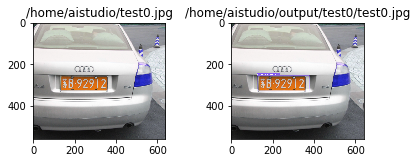

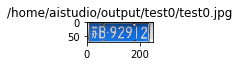

In [ ]:

# 模型测试可视化
import cv2
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

image_path_list = ['/home/aistudio/test0.jpg','/home/aistudio/output/test0/test0.jpg','/home/aistudio/output/test0/test0_frame0.jpg']
#label_path_list = [path.replace('images', 'labels').replace('jpg', 'png')
#                   for path in image_path_list]

plt.figure(figsize=(8, 8))
#for i in range(len(image_path_list)):
plt.subplot(len(image_path_list), 3, 1)
plt.title(image_path_list[0])
plt.imshow(cv2.imread(image_path_list[0]))

plt.subplot(len(image_path_list), 3, 2)
plt.title(image_path_list[1])
plt.imshow(cv2.imread(image_path_list[1]))
plt.tight_layout()
plt.show()

plt.subplot(len(image_path_list), 3, 3)
plt.title(image_path_list[1])
plt.imshow(cv2.imread(image_path_list[2]))
plt.tight_layout()
plt.show()

## 3.6 PaddleOCR预测检测框图图片的车牌信息

### 3.6.1 提取PaddleOCR代码，并安装依赖包

In [ ]:
#提取PaddleOCR代码，并安装依赖包
!git clone https://github.com/PaddlePaddle/PaddleOCR.git

Cloning into 'PaddleOCR'...
remote: Enumerating objects: 30309, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 30309 (delta 12), reused 21 (delta 3), pack-reused 30267
Receiving objects: 100% (30309/30309), 260.04 MiB | 597.00 KiB/s, done.
Resolving deltas: 100% (20867/20867), done.
Checking connectivity... done.


In [ ]:
#安装依赖包
%cd /home/aistudio/PaddleOCR/
!pip install -r requirements.txt

/home/aistudio/PaddleOCR
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 3.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 KB 3.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 603.5/603.5 KB 3.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.8/298.8 KB 5.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 KB 11.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.7/55.7 MB 2.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 2.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 2.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.9/178.9 KB 631.5 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.9/404.9 KB 2.6 MB/s eta 0:0

In [ ]:
#安装依赖包
%cd /home/aistudio/PaddleOCR/
!python setup.py install

/home/aistudio/PaddleOCR
running install
running bdist_egg
running egg_info
writing paddleocr.egg-info/PKG-INFO
writing dependency_links to paddleocr.egg-info/dependency_links.txt
writing entry points to paddleocr.egg-info/entry_points.txt
writing requirements to paddleocr.egg-info/requires.txt
writing top-level names to paddleocr.egg-info/top_level.txt
adding license file 'LICENSE' (matched pattern 'LICEN[CS]E*')
reading manifest file 'paddleocr.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'paddleocr.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
copying paddleocr.egg-info/PKG-INFO -> build/lib/paddleocr/paddleocr.egg-info
copying paddleocr.egg-info/SOURCES.txt -> build/lib/paddleocr/paddleocr.egg-info
copying paddleocr.egg-info/dependency_links.txt -> build/lib/paddleocr/paddleocr.egg-info
copying paddleocr.egg-info/entry_points.txt -> build/lib/paddleocr/paddleocr.egg-info
copy

### 3.6.2 下载ocr训练模型ch_ppocr_mobile_v2.0_rec，实现对PaddleDetection检测出的检测框的识别

In [ ]:
%cd /home/aistudio/
!wget https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_mobile_v2.0_rec_train.tar

/home/aistudio
--2022-02-22 23:21:41--  https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_mobile_v2.0_rec_train.tar
Resolving paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)... 182.61.200.229, 182.61.200.195, 2409:8c04:1001:1002:0:ff:b001:368a
Connecting to paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)|182.61.200.229|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5816724 (5.5M) [application/x-tar]
Saving to: ‘ch_ppocr_mobile_v2.0_rec_train.tar’

ch_ppocr_mobile_v2. 100%[===================>]   5.55M  7.85MB/s    in 0.7s    

2022-02-22 23:21:42 (7.85 MB/s) - ‘ch_ppocr_mobile_v2.0_rec_train.tar’ saved [5816724/5816724]



In [ ]:
import os
%cd /home/aistudio/
infer_path='/home/aistudio/infer'
if not os.path.exists(infer_path):
    os.mkdir(infer_path) 
!tar -xf /home/aistudio/ch_ppocr_mobile_v2.0_rec_train.tar -C /home/aistudio/infer

/home/aistudio


/home/aistudio/PaddleOCR
[2022/02/22 23:47:06] root INFO: Architecture : 
[2022/02/22 23:47:06] root INFO:     Backbone : 
[2022/02/22 23:47:06] root INFO:         model_name : small
[2022/02/22 23:47:06] root INFO:         name : MobileNetV3
[2022/02/22 23:47:06] root INFO:         scale : 0.5
[2022/02/22 23:47:06] root INFO:         small_stride : [1, 2, 2, 2]
[2022/02/22 23:47:06] root INFO:     Head : 
[2022/02/22 23:47:06] root INFO:         fc_decay : 1e-05
[2022/02/22 23:47:06] root INFO:         name : CTCHead
[2022/02/22 23:47:06] root INFO:     Neck : 
[2022/02/22 23:47:06] root INFO:         encoder_type : rnn
[2022/02/22 23:47:06] root INFO:         hidden_size : 48
[2022/02/22 23:47:06] root INFO:         name : SequenceEncoder
[2022/02/22 23:47:06] root INFO:     Transform : None
[2022/02/22 23:47:06] root INFO:     algorithm : CRNN
[2022/02/22 23:47:06] root INFO:     model_type : rec
[2022/02/22 23:47:06] root INFO: Eval : 
[2022/02/22 23:47:06] root INFO:     dataset :

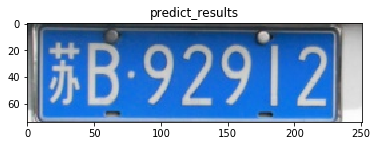

In [ ]:
%cd /home/aistudio/PaddleOCR/
!python tools/infer_rec.py \
    -c configs/rec/ch_ppocr_v2.0/rec_chinese_lite_train_v2.0.yml \
    -o \
        Global.pretrained_model=/home/aistudio/infer/ch_ppocr_mobile_v2.0_rec_train/best_accuracy \
        Global.infer_img=/home/aistudio/output/test0/test0_frame0.jpg \


plt.title('predict_results')
plt.imshow(cv2.imread('/home/aistudio/output/test0/test0_frame0.jpg'))
#plt.tight_layout()
plt.show()
        

# 4. 使用paddleocr串联检测模型和识别模型进行推理

## 4.1 下载解压ocr官方预训练识别模型

In [ ]:
%cd /home/aistudio/
!wget https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_server_v2.0_rec_infer.tar

/home/aistudio
--2022-02-21 09:57:48--  https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_server_v2.0_rec_infer.tar
Resolving paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)... 100.67.200.6
Connecting to paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)|100.67.200.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 112239104 (107M) [application/x-tar]
Saving to: ‘ch_ppocr_server_v2.0_rec_infer.tar.1’

ch_ppocr_server_v2. 100%[===================>] 107.04M   120MB/s    in 0.9s    

2022-02-21 09:57:49 (120 MB/s) - ‘ch_ppocr_server_v2.0_rec_infer.tar.1’ saved [112239104/112239104]



In [ ]:
import os
%cd /home/aistudio/
inference_path='/home/aistudio/inference'
if not os.path.exists(inference_path):
    os.mkdir(inference_path) 
!tar -xf /home/aistudio/ch_ppocr_server_v2.0_rec_infer.tar -C /home/aistudio/inference

/home/aistudio


## 4.2 检测模型转为推理模型

In [ ]:
%cd /home/aistudio/
!python ~/PaddleDetection/tools/export_model.py \
    -c ~/PaddleDetection/configs/yolov3/yolov3_mobilenet_v3_large_ssld_270e_ccpd_voc.yml \
    -o \
        weights=~/PaddleDetection/output/yolov3_mobilenet_v3_large_ssld_270e_ccpd_voc/best_model \
        output_dir=~/inference/yolov3_mobilenet_v3_large_ssld_270e_ccpd_voc\
        

/home/aistudio
[02/21 10:26:14] ppdet.utils.checkpoint INFO: Finish loading model weights: /home/aistudio/PaddleDetection/output/yolov3_mobilenet_v3_large_ssld_270e_ccpd_voc/best_model.pdparams
[02/21 10:26:14] ppdet.engine INFO: Export inference config file to output_inference/yolov3_mobilenet_v3_large_ssld_270e_ccpd_voc/infer_cfg.yml
W0221 10:26:17.769182 20908 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 10.1, Runtime API Version: 10.1
W0221 10:26:17.769224 20908 device_context.cc:465] device: 0, cuDNN Version: 7.6.
[02/21 10:26:25] ppdet.engine INFO: Export model and saved in output_inference/yolov3_mobilenet_v3_large_ssld_270e_ccpd_voc


## 4.3 模型串联测试

In [ ]:
!pip install paddleocr

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.4/288.4 KB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.6 MB/s eta 0:00:00a 0:00:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 603.5/603.5 KB 7.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.8/298.8 KB 8.1 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.7/55.7 MB 5.3 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 KB 7.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 3.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 5.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 KB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 7.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━

### 4.3.1 项目训练的检测模型串联识别模型的推理结果，目前检测出多个结果，上一节中paddle detection只检测出一个框，paddleocr对检测的框图进行识别时可以检测出车牌信息。

100%|██████████| 3.19M/3.19M [00:00<00:00, 37.7MiB/s]
100%|██████████| 1.45M/1.45M [00:00<00:00, 34.6MiB/s]

download https://paddleocr.bj.bcebos.com/PP-OCRv2/chinese/ch_PP-OCRv2_det_infer.tar to output_inference/yolov3_mobilenet_v3_large_ssld_270e_ccpd_voc/ch_PP-OCRv2_det_infer.tar


download https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_mobile_v2.0_cls_infer.tar to /home/aistudio/.paddleocr/2.4/ocr/cls/ch_ppocr_mobile_v2.0_cls_infer/ch_ppocr_mobile_v2.0_cls_infer.tar
Namespace(benchmark=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='/home/aistudio/.paddleocr/2.4/ocr/cls/ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='output_inference/yolov3_mobilenet_v3_large_ssld_270e_ccpd_voc', det_pse_box_thresh=0.85, det_pse_box_type='box', det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.5, e2e_algorithm=

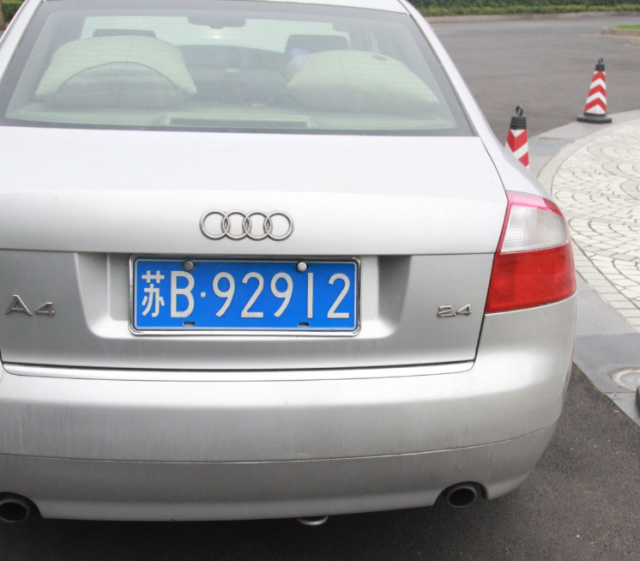

[2022/02/21 10:28:49] root WARNING: Since the angle classifier is not initialized, the angle classifier will not be uesd during the forward process
[2022/02/21 10:28:56] root DEBUG: dt_boxes num : 3, elapse : 6.323135852813721
[2022/02/21 10:28:56] root DEBUG: rec_res num  : 3, elapse : 0.026878833770751953


[[[[199.0, 207.0], [295.0, 210.0], [294.0, 245.0], [198.0, 242.0]],
  ('C0CO', 0.7045275)],
 [[[135.0, 261.0], [358.0, 264.0], [357.0, 326.0], [134.0, 322.0]],
  ('苏B·92912', 0.9947567)],
 [[[435.0, 305.0], [469.0, 303.0], [470.0, 317.0], [436.0, 320.0]],
  ('E4', 0.57693744)]]

In [ ]:
from paddleocr import PaddleOCR
from IPython.display import Image

vlpr = PaddleOCR(
    det_model_dir='output_inference/yolov3_mobilenet_v3_large_ssld_270e_ccpd_voc',
    rec_model_dir='inference/ch_ppocr_server_v2.0_rec_infer'
)
img_path = 'test0.jpg'
display(Image(img_path))
vlpr.ocr(img_path)

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 

### 4.3.2 fork项目中的训练检测模型串联推理结果

Namespace(benchmark=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='/home/aistudio/.paddleocr/2.4/ocr/cls/ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='inference/det_vlpr', det_pse_box_thresh=0.85, det_pse_box_type='box', det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model_dir=None, e2e_pgnet_mode='fast', e2e_pgnet_score_thresh=0.5, e2e_pgnet_valid_set='totaltext', enable_mkldnn=False, gpu_mem=500,

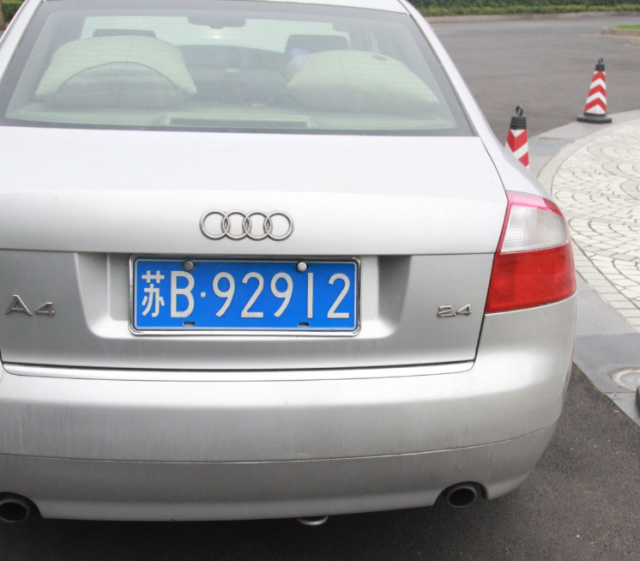

[2022/02/21 10:47:42] root WARNING: Since the angle classifier is not initialized, the angle classifier will not be uesd during the forward process
[2022/02/21 10:47:42] root DEBUG: dt_boxes num : 1, elapse : 0.024170875549316406
[2022/02/21 10:47:42] root DEBUG: rec_res num  : 1, elapse : 0.014237642288208008


[[[[130.0, 255.0], [366.0, 257.0], [365.0, 333.0], [129.0, 331.0]],
  ('苏B92912', 0.9392986)]]

In [ ]:
from paddleocr import PaddleOCR
from IPython.display import Image

vlpr = PaddleOCR(
    det_model_dir='inference/det_vlpr',
    rec_model_dir='inference/ch_ppocr_server_v2.0_rec_infer'
)
img_path = 'test0.jpg'
display(Image(img_path))
vlpr.ocr(img_path)

# 5.  参考[深度学习7日入门-CV疫情特辑](https://aistudio.baidu.com/aistudio/education/group/info/1149)课程车牌识别项目，实现cnn识别车牌信息。

In [ ]:
# 查看数据集的目录结构
# !tree data/xxx/xxx -d
! tree characterData -d

characterData
├── 0
├── 1
├── 2
├── 3
├── 4
├── 5
├── 6
├── 7
├── 8
├── 9
├── A
├── B
├── C
├── cuan
├── D
├── E
├── e1
├── F
├── G
├── gan
├── gan1
├── gui
├── gui1
├── H
├── hei
├── hu
├── J
├── ji
├── jin
├── jing
├── jl
├── K
├── L
├── liao
├── lu
├── M
├── __MACOSX
│   ├── 0
│   ├── 1
│   ├── 2
│   ├── 3
│   ├── 4
│   ├── 5
│   ├── 6
│   ├── 7
│   ├── 8
│   ├── 9
│   ├── A
│   ├── B
│   ├── C
│   ├── cuan
│   ├── D
│   ├── E
│   ├── e1
│   ├── F
│   ├── G
│   ├── gan
│   ├── gan1
│   ├── gui
│   ├── gui1
│   ├── H
│   ├── hei
│   ├── hu
│   ├── J
│   ├── ji
│   ├── jin
│   ├── jing
│   ├── jl
│   ├── K
│   ├── L
│   ├── liao
│   ├── lu
│   ├── M
│   ├── meng
│   ├── min
│   ├── N
│   ├── ning
│   ├── P
│   ├── Q
│   ├── qing
│   ├── qiong
│   ├── R
│   ├── S
│   ├── shan
│   ├── su
│   ├── sx
│   ├── T
│   ├── U
│   ├── V
│   ├── W
│   ├── wan
│   ├── X
│   ├── xiang
│   ├── xin
│   ├── Y
│   ├── yu
│   ├── yu1
│   ├── yue
│   ├── yun
│   ├── Z
│   ├── zang
│   └── zhe
├── meng
├─

In [ ]:
#导入需要的包
import os
import zipfile
import random
import json
import cv2
import numpy as np
from PIL import Image
import paddle
import paddle.fluid as fluid
from paddle.fluid.dygraph import Linear,Conv2D,Pool2D
import matplotlib.pyplot as plt

## 5.1 数据准备

In [ ]:
'''
参数配置
'''
train_parameters = {
    "input_size": [1, 20, 20],                           #输入图片的shape
    "class_dim": -1,                                     #分类数
    "src_path":"data/data47799/characterData.zip",       #原始数据集路径
    "target_path":"/home/aistudio/characterData",        #要解压的路径 
    "train_list_path": "./train_data.txt",              #train_data.txt路径
    "eval_list_path": "./val_data.txt",                  #eval_data.txt路径
    "label_dict":{},                                    #标签字典
    "readme_path": "/home/aistudio/data/readme.json",   #readme.json路径
    "num_epochs": 100,                                    #训练轮数
    "train_batch_size": 32,                             #批次的大小
    "learning_strategy": {                              #优化函数相关的配置
        "lr": 0.001                                     #超参数学习率
    } 
}

In [ ]:
def unzip_data(src_path,target_path):
    '''
    解压原始数据集，将src_path路径下的zip包解压至data/dataset目录下
    '''
    if(not os.path.isdir(target_path)):    
        z = zipfile.ZipFile(src_path, 'r')
        z.extractall(path=target_path)
        z.close()
    else:
        print("文件已解压")
        

In [ ]:
def get_data_list(target_path,train_list_path,eval_list_path):
    '''
    生成数据列表
    '''
    #存放所有类别的信息
    class_detail = []
    #获取所有类别保存的文件夹名称
    data_list_path=target_path
    class_dirs = os.listdir(data_list_path)
    if '__MACOSX' in class_dirs:
        class_dirs.remove('__MACOSX')
    # #总的图像数量
    all_class_images = 0
    # #存放类别标签
    class_label=0
    # #存放类别数目
    class_dim = 0
    # #存储要写进eval.txt和train.txt中的内容
    trainer_list=[]
    eval_list=[]
    #读取每个类别
    for class_dir in class_dirs:
        if class_dir != ".DS_Store":
            class_dim += 1
            #每个类别的信息
            class_detail_list = {}
            eval_sum = 0
            trainer_sum = 0
            #统计每个类别有多少张图片
            class_sum = 0
            #获取类别路径 
            path = os.path.join(data_list_path,class_dir)
            # print(path)
            # 获取所有图片
            img_paths = os.listdir(path)
            for img_path in img_paths:                                  # 遍历文件夹下的每个图片
                if img_path =='.DS_Store':
                    continue
                name_path = os.path.join(path,img_path)                       # 每张图片的路径
                if class_sum % 10 == 0:                                 # 每10张图片取一个做验证数据
                    eval_sum += 1                                       # eval_sum为测试数据的数目
                    eval_list.append(name_path + "\t%d" % class_label + "\n")
                else:
                    trainer_sum += 1 
                    trainer_list.append(name_path + "\t%d" % class_label + "\n")#trainer_sum测试数据的数目
                class_sum += 1                                          #每类图片的数目
                all_class_images += 1                                   #所有类图片的数目
            
            # 说明的json文件的class_detail数据
            class_detail_list['class_name'] = class_dir             #类别名称
            class_detail_list['class_label'] = class_label          #类别标签
            class_detail_list['class_eval_images'] = eval_sum       #该类数据的测试集数目
            class_detail_list['class_trainer_images'] = trainer_sum #该类数据的训练集数目
            class_detail.append(class_detail_list)  
            #初始化标签列表
            train_parameters['label_dict'][str(class_label)] = class_dir
            class_label += 1
            
    #初始化分类数
    train_parameters['class_dim'] = class_dim
    print(train_parameters)
    #乱序  
    random.shuffle(eval_list)
    with open(eval_list_path, 'a') as f:
        for eval_image in eval_list:
            f.write(eval_image) 
    #乱序        
    random.shuffle(trainer_list) 
    with open(train_list_path, 'a') as f2:
        for train_image in trainer_list:
            f2.write(train_image) 

    # 说明的json文件信息
    readjson = {}
    readjson['all_class_name'] = data_list_path                  #文件父目录
    readjson['all_class_images'] = all_class_images
    readjson['class_detail'] = class_detail
    jsons = json.dumps(readjson, sort_keys=True, indent=4, separators=(',', ': '))
    with open(train_parameters['readme_path'],'w') as f:
        f.write(jsons)
    print ('生成数据列表完成！')

In [ ]:
def data_reader(file_list):
    '''
    自定义data_reader
    '''
    def reader():
        with open(file_list, 'r') as f:
            lines = [line.strip() for line in f]
            for line in lines:
                img_path, lab = line.strip().split('\t')
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = np.array(img).astype('float32')
                img = img/255.0
                yield img, int(lab) 
    return reader

In [ ]:
'''
参数初始化
'''
src_path=train_parameters['src_path']
target_path=train_parameters['target_path']
train_list_path=train_parameters['train_list_path']
eval_list_path=train_parameters['eval_list_path']
batch_size=train_parameters['train_batch_size']
'''
解压原始数据到指定路径
'''
unzip_data(src_path,target_path)

#每次生成数据列表前，首先清空train.txt和eval.txt
with open(train_list_path, 'w') as f: 
    f.seek(0)
    f.truncate() 
with open(eval_list_path, 'w') as f: 
    f.seek(0)
    f.truncate() 
    
#生成数据列表   
get_data_list(target_path,train_list_path,eval_list_path)

'''
构造数据提供器
'''
train_reader = paddle.batch(data_reader(train_list_path),
                            batch_size=batch_size,
                            drop_last=True)
eval_reader = paddle.batch(data_reader(eval_list_path),
                            batch_size=batch_size,
                            drop_last=True)

文件已解压
{'input_size': [1, 20, 20], 'class_dim': 65, 'src_path': 'data/data47799/characterData.zip', 'target_path': '/home/aistudio/characterData', 'train_list_path': './train_data.txt', 'eval_list_path': './val_data.txt', 'label_dict': {'0': 'C', '1': 'zang', '2': 'J', '3': '9', '4': 'N', '5': 'cuan', '6': 'U', '7': 'ning', '8': 'meng', '9': 'A', '10': 'lu', '11': 'Z', '12': 'gui', '13': 'qiong', '14': 'yu', '15': 'ji', '16': '7', '17': 'M', '18': 'xiang', '19': 'H', '20': 'gui1', '21': 'D', '22': '4', '23': 'liao', '24': 'P', '25': 'e1', '26': '8', '27': 'B', '28': '3', '29': 'zhe', '30': 'jin', '31': 'yue', '32': '0', '33': 'shan', '34': '6', '35': 'T', '36': '2', '37': 'F', '38': 'jing', '39': 'X', '40': '5', '41': 'K', '42': 'min', '43': 'Y', '44': 'gan1', '45': 'yu1', '46': 'jl', '47': 'su', '48': 'sx', '49': 'hei', '50': 'wan', '51': 'hu', '52': 'G', '53': 'W', '54': 'L', '55': 'E', '56': 'yun', '57': 'xin', '58': 'qing', '59': 'V', '60': 'R', '61': 'gan', '62': 'S', '63': 'Q', '6

In [ ]:
Batch=0
Batchs=[]
all_train_accs=[]
def draw_train_acc(Batchs, train_accs):
    title="training accs"
    plt.title(title, fontsize=24)
    plt.xlabel("batch", fontsize=14)
    plt.ylabel("acc", fontsize=14)
    plt.plot(Batchs, train_accs, color='green', label='training accs')
    plt.legend()
    plt.grid()
    plt.show()

all_train_loss=[]
def draw_train_loss(Batchs, train_loss):
    title="training loss"
    plt.title(title, fontsize=24)
    plt.xlabel("batch", fontsize=14)
    plt.ylabel("loss", fontsize=14)
    plt.plot(Batchs, train_loss, color='red', label='training loss')
    plt.legend()
    plt.grid()
    plt.show()

## 5.2 定义模型

In [ ]:
class MyLeNet(fluid.dygraph.Layer):
    def __init__(self):
        super(MyLeNet,self).__init__()
        self.hidden1_1 = Conv2D(1,28,5,1) #通道数、卷积核个数、卷积核大小
        self.hidden1_2 = Pool2D(pool_size=2,pool_type='max',pool_stride=1)
        self.hidden2_1 = Conv2D(28,32,3,1)
        self.hidden2_2 = Pool2D(pool_size=2,pool_type='max',pool_stride=1)
        self.hidden3 = Conv2D(32,32,3,1)
        self.hidden4 = Linear(32*10*10,65,act='softmax')
    def forward(self,input):
        #print(input.shape)
        x = self.hidden1_1(input)
        #print(x.shape)
        x = self.hidden1_2(x)
        #print(x.shape)
        x = self.hidden2_1(x)
        #print(x.shape)
        x = self.hidden2_2(x)
        #print(x.shape)
        x = self.hidden3(x)
        #print(x.shape)
        x = fluid.layers.reshape(x, shape=[-1, 32*10*10])
        y = self.hidden4(x)

        return y

#定义DNN网络
'''
class MyDNN(fluid.dygraph.Layer):
    def __init__(self):
        super(MyDNN,self).__init__()
        self.hidden1 = Linear(20*20,200,act='relu')
        self.hidden2 = Linear(200,100,act='relu')
        self.hidden3 = Linear(100,100,act='relu')
        self.out = Linear(100,65,act='softmax')
    def forward(self,input):        # forward 定义执行实际运行时网络的执行逻辑
        x = fluid.layers.reshape(input, shape=[-1,20*20]) #-1 表示这个维度的值是从x的元素总数和剩余维度推断出来的，有且只能有一个维度设置为-1
        # print(x.shape)
        x = self.hidden1(x)
        # print('1', x.shape)
        x = self.hidden2(x)
        # print('2',x.shape)
        x = self.hidden3(x)
        # print('3',x.shape)
        y = self.out(x)
        # print('4',y.shape)
        return y
'''

"\nclass MyDNN(fluid.dygraph.Layer):\n    def __init__(self):\n        super(MyDNN,self).__init__()\n        self.hidden1 = Linear(20*20,200,act='relu')\n        self.hidden2 = Linear(200,100,act='relu')\n        self.hidden3 = Linear(100,100,act='relu')\n        self.out = Linear(100,65,act='softmax')\n    def forward(self,input):        # forward 定义执行实际运行时网络的执行逻辑\n        x = fluid.layers.reshape(input, shape=[-1,20*20]) #-1 表示这个维度的值是从x的元素总数和剩余维度推断出来的，有且只能有一个维度设置为-1\n        # print(x.shape)\n        x = self.hidden1(x)\n        # print('1', x.shape)\n        x = self.hidden2(x)\n        # print('2',x.shape)\n        x = self.hidden3(x)\n        # print('3',x.shape)\n        y = self.out(x)\n        # print('4',y.shape)\n        return y\n"

## 5.3 训练模型

train_pass:0,batch_id:50,train_loss:[2.7152138],train_acc:[0.4375]
train_pass:0,batch_id:100,train_loss:[2.1443958],train_acc:[0.46875]
train_pass:0,batch_id:150,train_loss:[2.0746415],train_acc:[0.53125]
train_pass:0,batch_id:200,train_loss:[2.0474901],train_acc:[0.5625]
train_pass:0,batch_id:250,train_loss:[1.3855617],train_acc:[0.71875]
train_pass:0,batch_id:300,train_loss:[0.8045807],train_acc:[0.90625]
train_pass:0,batch_id:350,train_loss:[1.086232],train_acc:[0.75]
train_pass:0,batch_id:400,train_loss:[0.96652156],train_acc:[0.84375]
train_pass:0,batch_id:450,train_loss:[0.991788],train_acc:[0.84375]
train_pass:1,batch_id:50,train_loss:[0.8165146],train_acc:[0.84375]
train_pass:1,batch_id:100,train_loss:[0.72529435],train_acc:[0.78125]
train_pass:1,batch_id:150,train_loss:[1.0004132],train_acc:[0.75]
train_pass:1,batch_id:200,train_loss:[0.98829263],train_acc:[0.75]
train_pass:1,batch_id:250,train_loss:[0.76637775],train_acc:[0.875]
train_pass:1,batch_id:300,train_loss:[0.3242298

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


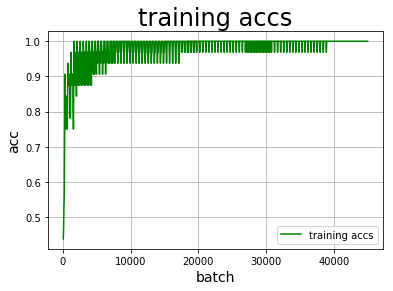

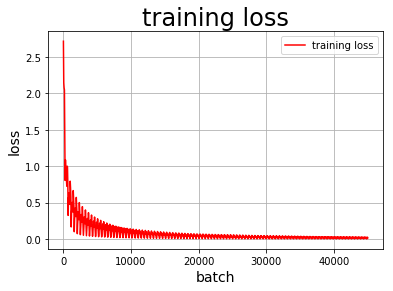

In [ ]:
with fluid.dygraph.guard():
    model=MyLeNet() #模型实例化
    model.train() #训练模式
    opt=fluid.optimizer.SGDOptimizer(learning_rate=train_parameters['learning_strategy']['lr'], parameter_list=model.parameters())#优化器选用SGD随机梯度下降，学习率为0.001.
    epochs_num=train_parameters['num_epochs'] #迭代次数
    
    for pass_num in range(epochs_num):
        for batch_id,data in enumerate(train_reader()):
            images=np.array([x[0].reshape(1,20,20) for x in data],np.float32)
            labels = np.array([x[1] for x in data]).astype('int64')
            labels = labels[:, np.newaxis]
            image=fluid.dygraph.to_variable(images)
            label=fluid.dygraph.to_variable(labels)

            predict=model(image) #数据传入model
            
            loss=fluid.layers.cross_entropy(predict,label)
            avg_loss=fluid.layers.mean(loss)#获取loss值
            
            acc=fluid.layers.accuracy(predict,label)#计算精度
            
            if batch_id!=0 and batch_id%50==0:
                Batch = Batch+50 
                Batchs.append(Batch)
                all_train_loss.append(avg_loss.numpy()[0])
                all_train_accs.append(acc.numpy()[0])
                
                print("train_pass:{},batch_id:{},train_loss:{},train_acc:{}".format(pass_num,batch_id,avg_loss.numpy(),acc.numpy()))
            
            avg_loss.backward()       
            opt.minimize(avg_loss)    #优化器对象的minimize方法对参数进行更新 
            model.clear_gradients()   #model.clear_gradients()来重置梯度
    fluid.save_dygraph(model.state_dict(),'MyLeNet')#保存模型

draw_train_acc(Batchs,all_train_accs)
draw_train_loss(Batchs,all_train_loss)

## 5.4 模型评估

In [ ]:
#模型评估
with fluid.dygraph.guard():
    accs = []
    model_dict, _ = fluid.load_dygraph('MyLeNet')
    model = MyLeNet()
    model.load_dict(model_dict) #加载模型参数
    model.eval() #训练模式
    for batch_id,data in enumerate(eval_reader()):#测试集
        images=np.array([x[0].reshape(1,20,20) for x in data],np.float32)
        labels = np.array([x[1] for x in data]).astype('int64')
        labels = labels[:, np.newaxis]
        image=fluid.dygraph.to_variable(images)
        label=fluid.dygraph.to_variable(labels)       
        predict=model(image)       
        acc=fluid.layers.accuracy(predict,label)
        accs.append(acc.numpy()[0])
        avg_acc = np.mean(accs)
    print(avg_acc)

0.9705882


## 5.5 使用模型

### 5.5.1 车牌图像进行预处理

In [32]:
# 对车牌图片进行处理，分割出车牌中的每一个字符并保存
image_full_path='车牌.png'
image_name,image_stype=image_full_path.split('.')
print(image_name)
license_plate = cv2.imread(image_full_path)
gray_plate = cv2.cvtColor(license_plate, cv2.COLOR_RGB2GRAY) 
ret, binary_plate = cv2.threshold(gray_plate, 175, 255, cv2.THRESH_BINARY) #ret：阈值，binary_plate：根据阈值处理后的图像数据
print('binary_plate.shape:',binary_plate.shape)
# 按列统计像素分布
result = []
for col in range(binary_plate.shape[1]):
    result.append(0)
    for row in range(binary_plate.shape[0]):
        result[col] = result[col] + binary_plate[row][col]/255
# print(result)
print('len(result):',len(result))
#记录车牌中字符的位置
character_dict = {}
num = 0
i = 0
while i < len(result):
    if result[i] == 0:
        i += 1
    else:
        index = i + 1
        while result[index] != 0:
            index += 1
        character_dict[num] = [i, index-1]
        num += 1
        i = index
# print(character_dict)        
#将每个字符填充，并存储
characters = []
for i in range(8):
    if i==2:
        continue
    padding = (170 - (character_dict[i][1] - character_dict[i][0])) / 2
    #将单个字符图像填充为170*170
    ndarray = np.pad(binary_plate[:,character_dict[i][0]:character_dict[i][1]], ((0,0), (int(padding), int(padding))), 'constant', constant_values=(0,0))
    ndarray = cv2.resize(ndarray, (20,20))
    image_save_full_path=os.path.join('cnn_infer',image_name , str(i) + '.png')
    image_save_path=os.path.join('cnn_infer',image_name )
    if not os.path.exists(image_save_path):
        os.makedirs(image_save_path)
        
    cv2.imwrite(image_save_full_path, ndarray)
    characters.append(ndarray)
    
def load_image(path):
    img = paddle.dataset.image.load_image(file=path, is_color=False)
    img = img.astype('float32')
    img = img[np.newaxis, ] / 255.0
    return img


车牌
binary_plate.shape: (170, 722)
len(result): 722


### 5.5.2 对标签进行转换

In [ ]:
#将标签进行转换
print('Label:',train_parameters['label_dict'])
match = {'A':'A','B':'B','C':'C','D':'D','E':'E','F':'F','G':'G','H':'H','I':'I','J':'J','K':'K','L':'L','M':'M','N':'N',
        'O':'O','P':'P','Q':'Q','R':'R','S':'S','T':'T','U':'U','V':'V','W':'W','X':'X','Y':'Y','Z':'Z',
        'yun':'云','cuan':'川','hei':'黑','zhe':'浙','ning':'宁','jin':'津','gan':'赣','hu':'沪','liao':'辽','jl':'吉','qing':'青','zang':'藏',
        'e1':'鄂','meng':'蒙','gan1':'甘','qiong':'琼','shan':'陕','min':'闽','su':'苏','xin':'新','wan':'皖','jing':'京','xiang':'湘','gui':'贵',
        'yu1':'渝','yu':'豫','ji':'冀','yue':'粤','gui1':'桂','sx':'晋','lu':'鲁',
        '0':'0','1':'1','2':'2','3':'3','4':'4','5':'5','6':'6','7':'7','8':'8','9':'9'}
L = 0
LABEL ={}
for V in train_parameters['label_dict'].values():
    LABEL[str(L)] = match[V]
    L += 1
print(LABEL)

Label: {'0': 'C', '1': 'zang', '2': 'J', '3': '9', '4': 'N', '5': 'cuan', '6': 'U', '7': 'ning', '8': 'meng', '9': 'A', '10': 'lu', '11': 'Z', '12': 'gui', '13': 'qiong', '14': 'yu', '15': 'ji', '16': '7', '17': 'M', '18': 'xiang', '19': 'H', '20': 'gui1', '21': 'D', '22': '4', '23': 'liao', '24': 'P', '25': 'e1', '26': '8', '27': 'B', '28': '3', '29': 'zhe', '30': 'jin', '31': 'yue', '32': '0', '33': 'shan', '34': '6', '35': 'T', '36': '2', '37': 'F', '38': 'jing', '39': 'X', '40': '5', '41': 'K', '42': 'min', '43': 'Y', '44': 'gan1', '45': 'yu1', '46': 'jl', '47': 'su', '48': 'sx', '49': 'hei', '50': 'wan', '51': 'hu', '52': 'G', '53': 'W', '54': 'L', '55': 'E', '56': 'yun', '57': 'xin', '58': 'qing', '59': 'V', '60': 'R', '61': 'gan', '62': 'S', '63': 'Q', '64': '1'}
{'0': 'C', '1': '藏', '2': 'J', '3': '9', '4': 'N', '5': '川', '6': 'U', '7': '宁', '8': '蒙', '9': 'A', '10': '鲁', '11': 'Z', '12': '贵', '13': '琼', '14': '豫', '15': '冀', '16': '7', '17': 'M', '18': '湘', '19': 'H', '20': '桂

### 5.5.3 使用模型进行预测

[10, 9, 34, 26, 34, 55, 2]
鲁A686EJ

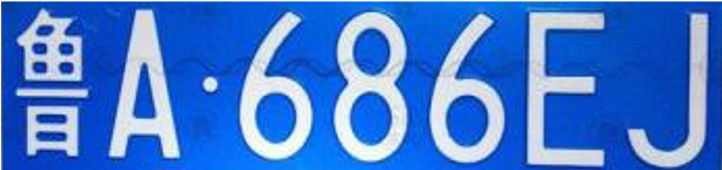

In [ ]:
#构建预测动态图过程
with fluid.dygraph.guard():
    model=MyLeNet()#模型实例化
    model_dict,_=fluid.load_dygraph('MyLeNet')
    model.load_dict(model_dict)#加载模型参数
    model.eval()#评估模式
    lab=[]
    for i in range(8):
        if i==2:
            continue
        infer_imgs = []
        infer_imgs.append(load_image('cnn_infer/'+image_name+'/' + str(i) + '.png'))
        infer_imgs = np.array(infer_imgs)
        infer_imgs = fluid.dygraph.to_variable(infer_imgs)
        result=model(infer_imgs)
        lab.append(np.argmax(result.numpy()))
print(lab)
display(Image.open('车牌.png'))
for i in range(len(lab)):
    print(LABEL[str(lab[i])],end='')


## 5.6 应用与检测框

### 5.6.1 车牌图像进行预处理

In [31]:
# 对车牌图片进行处理，分割出车牌中的每一个字符并保存
image_full_path='output/test0/test0_frame0.jpg'
_,image_name,image_frame_name_stype=image_full_path.split('/')
image_frame_name,image_stype=image_frame_name_stype.split('.')
print(image_name,image_frame_name)
license_plate = cv2.imread(image_full_path)
gray_plate = cv2.cvtColor(license_plate, cv2.COLOR_RGB2GRAY) 
ret, binary_plate = cv2.threshold(gray_plate, 175, 255, cv2.THRESH_BINARY) #ret：阈值，binary_plate：根据阈值处理后的图像数据
print('binary_plate.shape:',binary_plate.shape)
# 按列统计像素分布
result = []
for col in range(binary_plate.shape[1]):
    result.append(0)
    for row in range(binary_plate.shape[0]):
        result[col] = result[col] + binary_plate[row][col]/255
#print(result)
#print('result.shape:',result.shape)
print('len(result):',len(result))

#记录车牌中字符的位置
character_dict = {}
num = 0
i = 0
while i < len(result):
    if result[i] == 0:
        i += 1
    else:
        index = i + 1
        while result[index] != 0:
            index += 1
        character_dict[num] = [i, index-1]
        num += 1
        i = index
# print(character_dict)        
#将每个字符填充，并存储
characters = []
for i in range(8):
    if i==2:
        continue
    padding = (170 - (character_dict[i][1] - character_dict[i][0])) / 2
    #将单个字符图像填充为170*170
    ndarray = np.pad(binary_plate[:,character_dict[i][0]:character_dict[i][1]], ((0,0), (int(padding), int(padding))), 'constant', constant_values=(0,0))
    ndarray = cv2.resize(ndarray, (20,20))
    image_save_full_path=os.path.join('cnn_infer',image_frame_name , str(i) + '.jpg')
    image_save_path=os.path.join('cnn_infer',image_frame_name )
    if not os.path.exists(image_save_path):
        os.makedirs(image_save_path)
        
    cv2.imwrite(image_save_full_path, ndarray)
    characters.append(ndarray)
    
def load_image(path):
    img = paddle.dataset.image.load_image(file=path, is_color=False)
    img = img.astype('float32')
    img = img[np.newaxis, ] / 255.0
    return img

test0 test0_frame0
binary_plate.shape: (74, 251)
len(result): 251


IndexError: list index out of range

### 5.6.2 对标签进行转换

In [ ]:
#将标签进行转换
print('Label:',train_parameters['label_dict'])
match = {'A':'A','B':'B','C':'C','D':'D','E':'E','F':'F','G':'G','H':'H','I':'I','J':'J','K':'K','L':'L','M':'M','N':'N',
        'O':'O','P':'P','Q':'Q','R':'R','S':'S','T':'T','U':'U','V':'V','W':'W','X':'X','Y':'Y','Z':'Z',
        'yun':'云','cuan':'川','hei':'黑','zhe':'浙','ning':'宁','jin':'津','gan':'赣','hu':'沪','liao':'辽','jl':'吉','qing':'青','zang':'藏',
        'e1':'鄂','meng':'蒙','gan1':'甘','qiong':'琼','shan':'陕','min':'闽','su':'苏','xin':'新','wan':'皖','jing':'京','xiang':'湘','gui':'贵',
        'yu1':'渝','yu':'豫','ji':'冀','yue':'粤','gui1':'桂','sx':'晋','lu':'鲁',
        '0':'0','1':'1','2':'2','3':'3','4':'4','5':'5','6':'6','7':'7','8':'8','9':'9'}
L = 0
LABEL ={}
for V in train_parameters['label_dict'].values():
    LABEL[str(L)] = match[V]
    L += 1
print(LABEL)

### 5.6.3 使用模型进行预测

In [ ]:
#构建预测动态图过程
with fluid.dygraph.guard():
    model=MyLeNet()#模型实例化
    model_dict,_=fluid.load_dygraph('MyLeNet')
    model.load_dict(model_dict)#加载模型参数
    model.eval()#评估模式
    lab=[]
    for i in range(8):
        if i==2:
            continue
        infer_imgs = []
        infer_imgs.append(load_image('cnn_infer/'+image_name+'/' + str(i) + '.png'))
        infer_imgs = np.array(infer_imgs)
        infer_imgs = fluid.dygraph.to_variable(infer_imgs)
        result=model(infer_imgs)
        lab.append(np.argmax(result.numpy()))
print(lab)
display(Image.open('车牌.png'))
for i in range(len(lab)):
    print(LABEL[str(lab[i])],end='')
